# Testing PER functionality
This notebook tests the PER functionality using a simple example and a random Pauli noise model. This demsonstrates how the noise scaling procedure described can be used to carry out virtual zero-noise extrapolation for the measuring an observable after running an arbitrary circuit. The results show good agreement with the expected value even though the noise is measured at $[.8,1, 4]$, which are a significant distance from the zero-noise limit. The error in the expectation value is improved from 17% to .002% for one of the expectation values measured. Readout errors are not simulated, the SPAM reduction method does not contribute to this value. This agreement was reached at only 1000 samples from the QPD representation of the noise inverse, with a modest zero-noise overhead of 1.39. Readout errors are not simulated, the noise model is perfectly known, and there is no additional error from twirling, so this represents an ideal picture of the PER functionality.

In [1]:
from qiskit import QuantumCircuit, Aer
from matplotlib import pyplot as plt
import sys
from itertools import product
from qiskit.quantum_info import pauli_basis, Pauli, PTM
from qiskit.providers.aer.noise import NoiseModel, pauli_error
from qiskit.providers.fake_provider import FakeVigoV2
from random import random, choices
from scipy.optimize import nnls
import numpy as np

sys.path.append("../pauli_lindblad_per")
from per.perexperiment import PERExperiment
from framework.percircuit import PERCircuit
from tomography.noisedataframe import NoiseDataFrame
from framework.noisemodel import NoiseModel as PauliNoiseModel
from primitives.circuit import QiskitCircuit
from primitives.pauli import QiskitPauli

plt.style.use("ggplot")
import matplotlib

## Mitigated expectation value
This creates an example quantum circuit to mitigate. This example only uses one distinct type of layer for simplicity. The $RZ(\frac{\pi}{4})$ gates are chosen to demonstrate how the twirling can be performed even when there are non clifford gates in the circuit. The final measurements in the $X$ basis are not included in the circuit, as these are incorporated separately into the mitigation scheme.

In [2]:
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.rz(np.pi/4,0)
qc.cx(0,1)
qc.rz(np.pi/4,0)
qc.cx(0,1)
qc.rz(np.pi/4,0)
qc.cx(0,1)
qc.rz(np.pi/4,0)
qc.cx(0,1)
qc.draw()

┌───┐┌─────────┐     ┌─────────┐     ┌─────────┐     ┌─────────┐     
q_0: ┤ H ├┤ Rz(π/4) ├──■──┤ Rz(π/4) ├──■──┤ Rz(π/4) ├──■──┤ Rz(π/4) ├──■──
     ├───┤└─────────┘┌─┴─┐└─────────┘┌─┴─┐└─────────┘┌─┴─┐└─────────┘┌─┴─┐
q_1: ┤ H ├───────────┤ X ├───────────┤ X ├───────────┤ X ├───────────┤ X ├
     └───┘           └───┘           └───┘           └───┘           └───┘

### Break circuit into layers
The circuit is wrapped in a `QiskitCircuit` object, which is an interface used to interact with different circuit representations, such as the qiskit `QuantumCircuit`. The `PERCircuit` object takes care of breaking up the circuit into layers looking like single-qubit layers followed by layers of self-adjoint two-qubit clifford gates with disjoint supports. Although this is part of the private interface, it is illustrated below:

In [3]:
circ = QiskitCircuit(qc)
percirc = PERCircuit(circ)

drawer = QiskitCircuit(qc).copy_empty()
for l in percirc._layers:
    drawer.compose(l.single_layer)
    drawer.compose(l.cliff_layer)
    drawer.barrier()

drawer.qc.draw()

┌───┐┌─────────┐      ░ ┌─────────┐      ░ ┌─────────┐      ░ ┌─────────┐»
q_0: ┤ H ├┤ Rz(π/4) ├──■───░─┤ Rz(π/4) ├──■───░─┤ Rz(π/4) ├──■───░─┤ Rz(π/4) ├»
     ├───┤└─────────┘┌─┴─┐ ░ └─────────┘┌─┴─┐ ░ └─────────┘┌─┴─┐ ░ └─────────┘»
q_1: ┤ H ├───────────┤ X ├─░────────────┤ X ├─░────────────┤ X ├─░────────────»
     └───┘           └───┘ ░            └───┘ ░            └───┘ ░            »
«           ░ 
«q_0: ──■───░─
«     ┌─┴─┐ ░ 
«q_1: ┤ X ├─░─
«     └───┘ ░

## Create Noise Model
The simulated noise mosel is a random Pauli noise model, used to test the ability of PER to handle arbitrary twirled noise channels. Random Pauli operators are chosen to define the channel, and then the transfer matrix is used to extract the fidelities. Then, the generated error model is processed through the non-negative least squares algorithm to get the ideal noise coefficients.

In [4]:
num = 4  #number of errors
errorops = choices(pauli_basis(2, pauli_list = True), k=num) #choose random pauli errors
errorprobs = [random()*.1/num for op in errorops] #assign random probabilities

#create normalized error model
twoqubit_error = pauli_error([(op, p) for op,p in zip(errorops, errorprobs)]+[(Pauli("II"), 1-sum(errorprobs))])
noise_model = NoiseModel()

#add error model to two-qubit gates.
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])

#Get transfer matrix to find fidelities
real_errors = {}
transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data
for i,pauli in enumerate(pauli_basis(2, pauli_list = True)):
    real_errors[pauli] = transfer_matrix[i][i]

#Define the symplectic inner product, get model terms, and generate matrix
sprod = lambda a,b: int(not a.commutes(b))
model_terms = [QiskitPauli("".join(s)) for s in product("IXYZ", repeat = 2)]
m1 = [[sprod(a,b) for a in model_terms] for b in model_terms]
 
#Use least squares algorithm to determine simulated model coefficients from chosen fidelities
coeffs, rnorm = nnls(m1, -.5*np.log([real_errors[term.pauli].real for term in model_terms]))

In [5]:
#Create a noise model to represent the simulated errors.
#This would usually be collected through tomography
circuit_layer = percirc._layers[0].cliff_layer
nm = PauliNoiseModel(percirc._layers[0].cliff_layer, model_terms[1:], coeffs[1:])

#Create ideal readout model with no readout errors
single_weights = [QiskitPauli("I"+"".join(s)) for s in product("XYZ")] \
    +[QiskitPauli("".join(s)+"I") for s in product("XYZ")]

#Set up noise model for PER as a NoiseDataFrame
readout_model = {p: 1.0 for p in single_weights}
noisedataframe = NoiseDataFrame([nm], readout_model)

In [6]:
#define a noisy executor
def executor(circuits):
    return Aer.get_backend("qasm_simulator").run(circuits, noise_model = noise_model, shots = 500).result().get_counts()

## Ideal and noisy expectation values
In order to measure the effect of mitigation, the ideal expectation values of several operators and the expectations of these operators with no mitigation are simulated here:

In [7]:
meas_circ = qc.copy()
meas_circ.h(0)
meas_circ.h(1)
meas_circ.measure_all()
counts = Aer.get_backend("qasm_simulator").run(meas_circ).result().get_counts()
shots = sum(counts.values())
print("Ideal reasult:", counts)
print("IX:", (counts.get('10',0)+counts.get('11',0)-counts.get('00',0)-counts.get('01',0))/shots)
print("XI:", (counts.get('01',0)+counts.get('11',0)-counts.get('00',0)-counts.get('10',0))/shots)

Ideal reasult: {'01': 1024}
IX: -1.0
XI: 1.0


In [22]:
noisy_counts = executor(meas_circ)
shots = sum(noisy_counts.values())
print("Noisy result:", noisy_counts)
print("IX:", (noisy_counts.get('00',0)+noisy_counts.get('10',0)-noisy_counts.get('01',0)-noisy_counts.get('11',0))/shots)
print("XI:", (noisy_counts.get('00',0)+noisy_counts.get('01',0)-noisy_counts.get('10',0)-noisy_counts.get('11',0))/shots)

Noisy result: {'00': 29, '01': 448, '10': 11, '11': 12}
IX: -0.84
XI: 0.908


## Run error mitigation
As demonstrated in the tutorial notebook, the error mitigation can be run in several steps:
* Create experiment
* Generate circuits
* Pass to noisy executor
* Analyze results
    

In [9]:
#Create experiment
perexp = PERExperiment([qc], [0,1], noisedataframe, FakeVigoV2())

#Generate circuits by sampling from twirl + noise inverse
perexp.generate(expectations = ["IX","XI"], samples = 1000, noise_strengths = [.8,1,4])

#run the circuits with the noisy executor
perexp.run(executor)

#analyze and extract results
circuit_results = perexp.analyze()

#print total circuit overhead of circuit 1 with no noise
print(perexp.get_overhead(0, 0))

1.3932335517637886


## Plot expectation values

Error-Mitigated Expectation: -0.9982563165317633


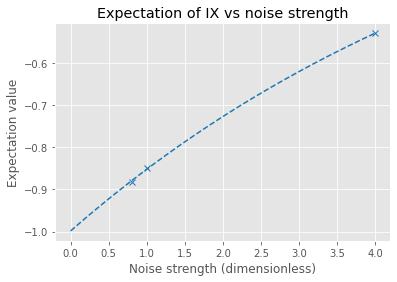

In [13]:
result, = circuit_results
IX = result.get_result("IX")
ax = IX.plot()
plt.title("Expectation of IX vs noise strength")
plt.xlabel("Noise strength (dimensionless)")
plt.ylabel("Expectation value")
print("Error-Mitigated Expectation:",IX.expectation)

Error-Mitigated Expectation: 0.9930947609238502


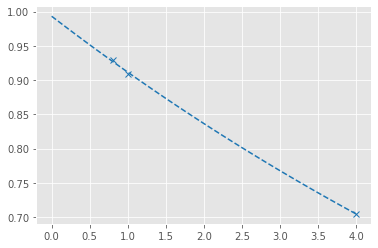

In [14]:
XI = result.get_result("XI")
XI.plot()
print("Error-Mitigated Expectation:",XI.expectation)

In [25]:
print("IX:")
print("ideal result:", (counts.get('10',0)+counts.get('11',0)-counts.get('00',0)-counts.get('01',0))/sum(counts.values()))
print("noisy result:", (noisy_counts.get('00',0)+noisy_counts.get('10',0)-noisy_counts.get('01',0)-noisy_counts.get('11',0))/sum(noisy_counts.values()))
print("Error-Mitigated Expectation:",IX.expectation)
print()
print("XI:")
print("ideal result:", (counts.get('01',0)+counts.get('11',0)-counts.get('00',0)-counts.get('10',0))/sum(counts.values()))
print("noisy result:", (noisy_counts.get('01',0)+noisy_counts.get('00',0)-noisy_counts.get('10',0)-noisy_counts.get('11',0))/sum(noisy_counts.values()))
print("Error-Mitigated Expectation:",XI.expectation)

IX:
ideal result: -1.0
noisy result: -0.84
Error-Mitigated Expectation: -0.9982563165317633

XI:
ideal result: 1.0
noisy result: 0.908
Error-Mitigated Expectation: 0.9930947609238502
